# [Computational Social Science]
## 5-2 Exploratory Data Analysis and Unsupervised Methods - Student Version

This lab will demonstrate some exploratory methods for finding separating words, and introduce unsupervised topic models.

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. 

<br>

If you have already created a virtual enviornment, you can run the following command to activate it: 

<br>

`conda activate <virtual_env_name>`

<br>

For example, if your virtual environment was named as CSS, run the following command. 

<br>

`conda activate CSS`

<br>

To deactivate your virtual environment after you are done working with the lab, run the following command. 

<br>

`conda deactivate`

<br>

In [1]:
# download libraries
# ----------
!pip install scattertext
!pip install wordcloud
!pip install textblob

In [2]:
# load libraries
# ----------
import pandas as pd
import numpy as np
from PIL import Image
import spacy
import en_core_web_sm
import scattertext as st
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt

# settings 
%matplotlib inline

## Data

<img src = "../../images/cfpb_logo.png"/>

We'll once again use the Consumer Financial Protection Bureau's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). This time, we are going to focus on figuring out whether we can find text features that help distinguish different "Products." There are several products represented in the dataset:

In [3]:
# load the data
# ----------

# load the dataframe
cfpb = pd.read_csv("../../data/CFPB 2020 Complaints.csv")

# drop missing on "Consumer complaint narrative" feature and reset the index bc we've dropped
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])# not reseting the index here bc doing some other cleaning

# identify the unique characters is Product column
cfpb['Product'].unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Checking or savings account',
       'Money transfer, virtual currency, or money service',
       'Payday loan, title loan, or personal loan',
       'Credit card or prepaid card', 'Mortgage', 'Vehicle loan or lease',
       'Student loan'], dtype=object)

For the first few exercises, we will focus on mortgages and student loans. We will also just use the first one thousand observations so that the code runs faster. 

In [4]:
# filter out only columns where product == "Mortgage" or "Student loan"
cfpb = cfpb[(cfpb['Product']=='Mortgage') | (cfpb['Product'] == 'Student loan')]

# subset the first 1000 rows 
cfpb = cfpb[:1000]

In [5]:
# view 
# ----------
cfpb.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
213,01/20/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,None,"I have been contacting OCWEN MORTGAGE, PHH MOR...",Company believes it acted appropriately as aut...,Ocwen Financial Corporation,LA,None,Servicemember,Consent provided,Web,02/18/20,Closed with explanation,Yes,NaN,3502248
216,01/15/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,None,We purchased our house in XX/XX/XXXX the Assig...,None,Ocwen Financial Corporation,ID,None,None,Consent provided,Web,02/10/20,Closed with explanation,Yes,NaN,3497147
283,03/28/20,Mortgage,VA mortgage,Closing on a mortgage,None,I had past issues with Mortgage Solutions of C...,None,MORTGAGE SOLUTIONS OF COLORADO,TX,None,Servicemember,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3583812
293,03/31/20,Mortgage,VA mortgage,Trouble during payment process,None,I have called Nationstar multiple times to req...,Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE,MN,551XX,Servicemember,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3586865
387,03/31/20,Mortgage,VA mortgage,Struggling to pay mortgage,None,All documents for the short sale review were s...,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",VA,None,None,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3588118


## Preprocessing

Let's start by creating our tokens. We'll use the same `rem_punc_stop()` function we defined last time.

In [6]:
# create preprocessing function - just like we did in the last lab
# ----------
def rem_punc_stop(text):

    # set objects
    stop_words = STOP_WORDS         # set STOP_WORDS to a new object variable
    punc = set(punctuation)         # convert punctuation to a set
    
    # essentially remove the punctuation - important to remove punctuation first to correctly capture stop words
    punc_free = "".join([ch for ch in text if ch not in punc]) # join new list of characters (ch) in text w/ condition
                                                               # if ch is not in punctuation 
                                                               # "".join() creates a string from the list comprehension

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # extract words from processed text 
    spacy_words = [token.text for token in doc]
    
    # filter out words 
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    # return
    return no_punc

Notice here how we use the `map()` function to apply our `rem_punc_stop()` function to every row of our dataframe. `map()` is typically much faster than writing a for loop, though there are also faster options like [list comprehensions](https://docs.python.org/3/tutorial/datastructures.html) and vectorized numpy arrays.

In [8]:
# now apply the function to all the columns in our dataframe
# ----------
# cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x)) # can use apply here 
cfpb['tokens'] = [rem_punc_stop(line) for line in cfpb['Consumer complaint narrative']]
cfpb['tokens'] # visualize

213      [I, contacting, OCWEN, MORTGAGE, PHH, MORTGAGE...
216      [We, purchased, house, XXXXXXXX, Assignment, D...
283      [I, past, issues, Mortgage, Solutions, Colorad...
293      [I, called, Nationstar, multiple, times, reque...
387      [All, documents, short, sale, review, sent, XX...
                               ...                        
33836    [I, contacted, XXXX, XXXX, offering, complete,...
33855    [One, parent, plus, loan, opened, XXXXXXXX, ch...
33860    [TCF, refusing, provide, account, information,...
33880    [We, asking, loan, modification, years, In, pa...
33896    [loan, bayview, loan, services, went, 3,  , XX...
Name: tokens, Length: 1000, dtype: object

## Word Cloud

One of the most popular text analysis visualizations is the word cloud. Word clouds visualize the most frequent words in a corpus, and size them according to frequency.

In [9]:
WordCloud?

Init signature:
WordCloud(
    font_path=None,
    width=400,
    height=200,
    margin=2,
    ranks_only=None,
    prefer_horizontal=0.9,
    mask=None,
    scale=1,
    color_func=None,
    max_words=200,
    min_font_size=4,
    stopwords=None,
    random_state=None,
    background_color='black',
    max_font_size=None,
    font_step=1,
    mode='RGB',
    relative_scaling='auto',
    regexp=None,
    collocations=True,
    colormap=None,
    normalize_plurals=True,
    contour_width=0,
    contour_color='black',
    repeat=False,
    include_numbers=False,
    min_word_length=0,
    collocation_threshold=30,
)
Docstring:     
Word cloud object for generating and drawing.

Parameters
----------
font_path : string
    Font path to the font that will be used (OTF or TTF).
    Defaults to DroidSansMono path on a Linux machine. If you are on
    another OS or don't have this font, you need to adjust this path.

width : int (default=400)
    Width of the canvas.

height : int (default=2

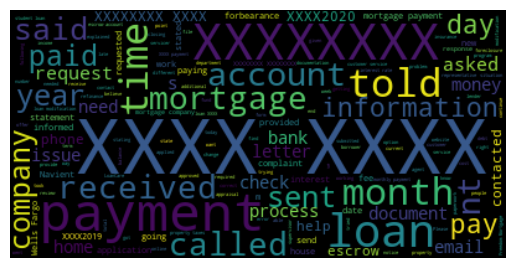

In [10]:
# now apply the function to all the columns in our dataframe
# ----------
# apply function to text object
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(random_state=40).generate(text)

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

There are lots of ways to customize a word cloud, including by changing the background color:

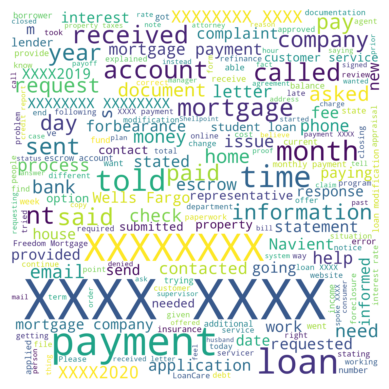

In [16]:
# same word cloud as above but changing background parameters
# ----------
# apply function to text object
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color='white',             # set background color to white
                      random_state=41,
                        width=1500,
                        height=1500,  # set random state to ensure same word cloud each time
                      ).generate(text)            # change the background color



# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed 
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

And we can even overlay the wordcloud onto an image:

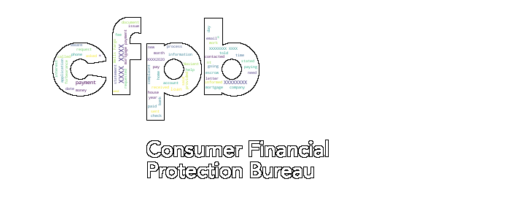

In [14]:
# spread the word cloud over the CFPB logo
# ----------
# load image
cfpb_mask = np.array(Image.open("../../images/cfpb_logo.png"))

# create word cloud
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))

# specify parameters of the wordcloud
wordcloud = WordCloud(background_color='white',                # set background color to white
                      random_state=77,           # set random state to ensure same word cloud each time
                      mask = cfpb_mask,          # mask is necessary 
                      contour_width=0.0001,      # provides an outline for clarity
                      width = 1500,
                      height = 1500).generate(text)

# plot 
plt.imshow(wordcloud,                   # specify wordcloud
           interpolation = 'bilinear')  # specifies how the words are displayed
plt.axis('off')                         # turn off axes
plt.show()                              # show the plot

### Challenge

Notice that in the above word clouds, tokens like "XXXX" and "XXXXXXXX" appear frequently. These are redacted dates and likely won't help us with classification. Try to rewrite `rem_punc_stop` to remove these.

**Hint**: Try taking a look at `nlp.Defaults.stop_words` and see if there are any associated methods that might help.

{'empty', 'am', 'neither', '‘ll', 'after', 'one', 'per', 'whenever', 'perhaps', 'whose', 'a', 'or', 'an', 'below', 'although', 'thereby', 'of', 'ca', 'still', 'take', 'when', '’s', 'whereupon', 'yet', 'herself', 'being', 'wherein', 'whatever', 'does', 'sometimes', 'could', 'nowhere', 'everywhere', 'call', 'along', 'amount', 'were', '’d', 'seem', 'there', 'us', 'toward', '‘m', 'made', 'used', 'regarding', 'up', 'via', 'last', 'hereupon', 'nothing', 'would', 'my', 'ours', "n't", 'sometime', 'yourselves', 'own', '’ll', 'done', 'go', 'himself', 'are', 'beforehand', 'whither', 'them', 'thereupon', 'ourselves', 'since', 'he', 'n’t', 'get', 'through', 'whoever', 'many', 'anything', 'other', 'onto', '’re', 'nine', 'throughout', 'becoming', 'did', 'latter', 'top', "'d", 'around', 'for', 'above', 'thru', 'in', 'whereafter', 'first', 'why', 'once', 'then', 'over', 'to', 'anywhere', 'front', 'three', 'where', 'which', 'bottom', 'who', 'seems', 'you', 'seeming', 'him', 'beyond', 'formerly', 'among'

In [22]:
# rewrite the rem_punc_stop function to remove redacted account numbers (e.g, "XXX")
# ----------

def rem_punc_stop(text):
    stop_words = STOP_WORDS

    # remove stop word
    nlp.Defaults.stop_words|= {"XXXX","XXXXXXXX","XX"}
    
    # convert punctuation to set
    punc = set(punctuation)
    
    # essentially remove the punctuation - important to remove punctuation first to correctly capture stop words
    punc_free = "".join([ch for ch in text if ch not in punc]) # join new list of characters (ch) in text w/ condition
                                                               # if ch is not in punctuation 
                                                               # "".join() creates a string from the list comprehension

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # extract words from processed text 
    spacy_words = [token.text for token in doc]
    
    # filter out words 
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    # return
    return no_punc

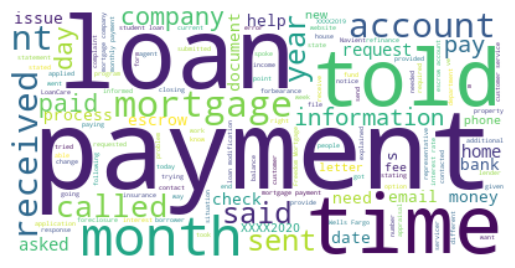

In [23]:
# recreate word cloud from above 
# ----------

# need to do preprocessing again and re-create "tokens" column
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))

# apply function to text object
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color='white',                  # specify white background
                     random_state=42         # set seeed
                     ).generate(text)         # generate from text dataset


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

**Bonus**: This is an example where using [regular expressions](https://docs.python.org/3/library/re.html) can be useful. Instead of inputting all of the different ways that something like "XX" might show up, you can use regex to find and remove all similar patterns.

## Lengths and Counts

One of the basic things we might look for when analyzing text data is the length of a document. Let's see how we might grab the total number of characters and the total number of words:

In [24]:
# create new feature columns with counts of # of characters and # of words
# ----------

# count number of characters
cfpb['complaint_len'] = cfpb['Consumer complaint narrative'].apply(len)

# count number of words
cfpb['word_count'] = cfpb['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))

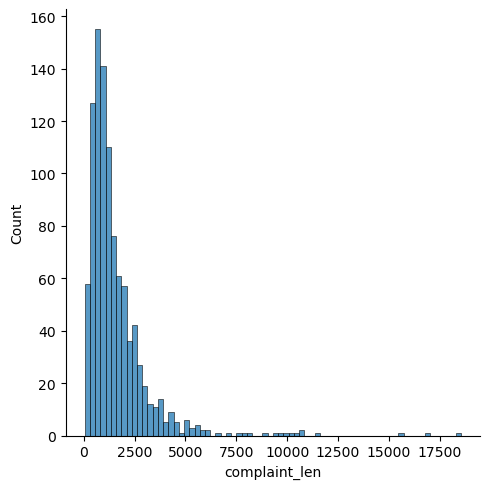

In [26]:
# create histogram of complaint length (number of characters)
sns.displot(cfpb,               # specify data
            x="complaint_len") # x-axis feature
plt.show()

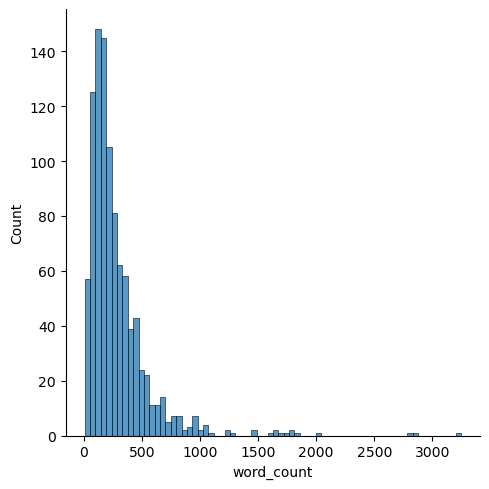

In [27]:
# create histogram of word count
sns.displot(cfpb,            # specify data
            x="word_count") # x-axis feature
plt.show()

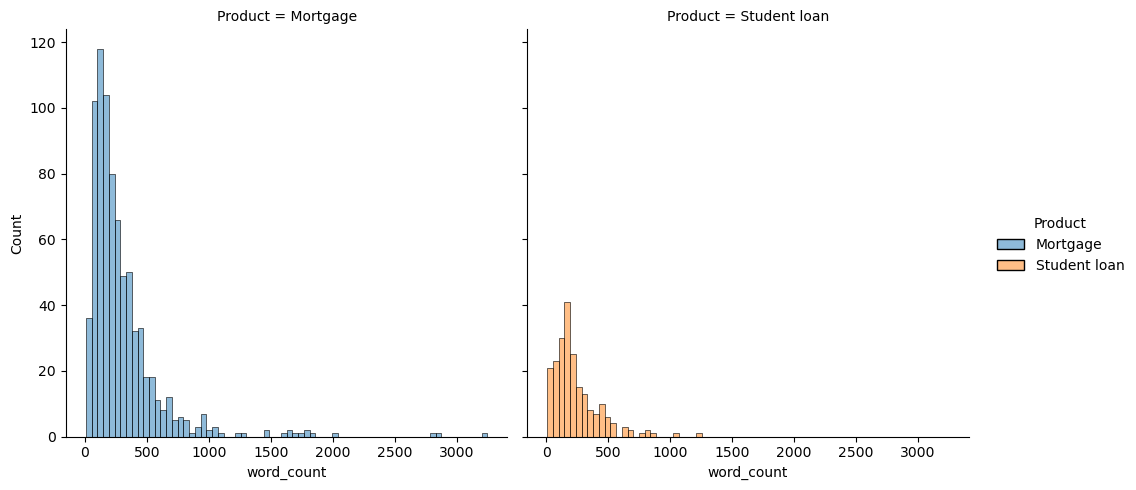

In [31]:
# histogram of word count by loan product 
sns.displot(cfpb,              # specify data
            x="word_count",   # x-axis feature
            hue = "Product",  # color by loan product
            col = "Product")  # column by loan product
plt.show()

## Sentiment Polarity

A common area of research in the social sciences is thinking about the "sentiment" of a text. The [`TextBlob`](https://textblob.readthedocs.io/en/dev/quickstart.html) library gives us access to a pre-trained sentiment analysis model. Text might be characterized as "positive," "negative," or "neutral" on a [-1,1] scale with -1 being highly negative and 1 being highly positive. Before we look at the code, do you expect that the sentiment scores for these data should be negative or positive? 

In [ ]:
# create a feature colum of sentiment polarity
# ---------- 
# create the "tokens" column again 
cfpb['tokens'] = cfpb['tokens'].map(lambda text: ' '.join(text))

# create the "tokens" column again 
cfpb['polarity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

# view
cfpb.head()

In [ ]:
# histogram of polarity
sns.displot(...,         # specify data
            x="...")     # x-axis label 
plt.show()

What's going on here? Why does sentiment look so close to neural, or even slightly positive? We know that all of the narratives in this dataset are consumer **complaints**, so we should expect them to look somewhat negative. Let's look at the 5 most positive reviews:

In [ ]:
# loop to view the 5 most positive reviews
# ---------- 
for complaint in cfpb.nlargest(5, 'polarity')['Consumer complaint narrative']:
    print(complaint + "\n")

Do we have any words that are skewing things? Let's look at the sentiment score for this first comment, and the individual sentiments of the words in it:

In [ ]:
# focus on the first complaint and view its overall polarity 
# ---------- 
# create string capturing the first complaint above for analysis
sample_complaint = "the company said they are offering a covid relief program which I requested assistance and they are saying a balloon payment is owed in XXXX I called the company and I was told that if I can't make this payment they will be talking taking litigation steps how are people who have lost their job able to keep their homes"

# print polarity score
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.polarity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.polarity)

Only one word actually has a sentiment score ("able")! TextBlob's sentiment polarity is not a simple average of all of the sentiments in a string - this is why preprocessing is important and why you should validate these types of off-the-shelf methods. Let's take a look at the most negative reviews and see if these make sense:

In [ ]:
# loop to view the 5 most negative reviews
# ---------- 
for complaint in cfpb.nsmallest(5, 'polarity')['Consumer complaint narrative']:
    print(complaint + '\n')

In [ ]:
# focus on the first complaint and view its overall polarity 
# ---------- 
# create string capturing the first complaint above for analysis
sample_complaint = "Navient is the worst company to ever exist. Website does not work. Do the people at customer service even work for navient??? They don't know anything about whats going on. Applied for a repayement plan and their website always says an error has occured."

# print polarity score
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.polarity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.polarity)

In this case we have a perfectly negative sentiment (-1.0), but again only one word is contirbuting - "worst". Sentiment polarity is a powerful tool, but not automatically suited to inference. That being said, maybe it can be helpful for distinguishing between labels. We can take a look at how polarity differs across mortgage and student loans. 

Is cutting the data this way helpful or not?

In [ ]:
# histogram of polarity by loan product
sns.displot(...,             # specify data
            x="polarity",    # specify x-axix feature 
            hue = "Product", # color by loan product
            col = "Product") # color by loan product
plt.show()

### Challenge

In addition to sentiment polarity, TextBlob also has a method for determining how "objective" or "subjective" a piece of text is. Plot the objectivity measure by loan product. Do these results make sense?

In [ ]:
# create measure of subjectivity
# ---------- 

# create new column feature of subjectivity
cfpb['subjectivity'] = cfpb[...].map(lambda... .sentiment.subjectivity)

# plot
sns.displot(...) 
plt.show()

**ANSWER**: ...

## ScatterText

Next we'll take a look at a useful visualization for finding separarting words. We'll use the [ScatterText](https://spacy.io/universe/project/scattertext) library to visualize both word frequencies and how well they separate two classes.

In [ ]:
# create measure of subjectivity
# ---------- 
corpus = st.CorpusFromPandas(cfpb[:5000],              # specify data
                             category_col = 'Product', # specify the explanatory variable  
                             text_col = 'tokens',      # specify the text column
                             nlp = nlp).build()        # apply the nlp algorithim and build

In [ ]:
# create html document
html = st.produce_scattertext_explorer(corpus,
                                       category='Student loan',
                                       category_name='Student loan',
                                       not_category_name='Mortgage',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5,
                                       metadata=cfpb['Complaint ID'])

In [ ]:
# write html document to memory and open in browser
open("CFPB Sentiment.html", 'wb').write(html.encode('utf-8'))

## Unsupervised Methods

Finally, we'll look at unsupervised machine learning methods for text data. Specifically, we'll implement [Kmeans Clustering], which is a simple and commonly used unsupervised machine learning methods, and [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation), which is a classic method for topic modeling. Topic models can help us uncover structure within a text. Specifically it does so through a "mixture model" - meaning every document is assumed to be "about" various topics, and we try to estimate the proportion each topic contributes to a document. Let's reload our cfpb dataset and look at "checkings or savings account" and "student loan" products this time:

In [ ]:
# load and process data
# ---------- 
cfpb = pd.read_csv("../../data/CFPB 2020 Complaints.csv")
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])
cfpb = cfpb[(cfpb['Product']=='Checking or savings account') | (cfpb['Product'] == 'Student loan')]
cfpb = cfpb[:1000]

Let's start by creating our tf-idf matrix again. Note that this might take a bit because were are working with 1000 rows.

In [ ]:
# create tf-idf matrix
# ----------
# set X dataset
X = cfpb['Consumer complaint narrative']        

# initialize tf-idf using our preprocessing function
tf = TfidfVectorizer(tokenizer = ...,           # use our function for tokenizing created above
                     token_pattern = None)      # set to "None" since we have specify our own pattern

# fit to data
tfidf_matrix =  tf....

# create dense matrix to view
dense_matrix = tfidf_matrix....
dense_matrix

### KMeans clustering

Let's implement a simple kmeans clustering algorithim and add those labels (which cluster each record belongs to) back to our dataframe.

In [ ]:
# kmeans clustering
# ---------- 
# import kmean library
from sklearn.cluster import KMeans

# implement kmeans clustering
kmeans = KMeans(...,                # specify 3 of clusters
                ...                 # specify 300 of iterations
                ).fit(tfidf_matrix) # specify data to fit

In [ ]:
# We can access the centers of the clusters through the cluster_centers_ attribute. To get the labels 
#(i.e. the corresponding cluster) we use labels_.
cfpb['cluster']= kmeans.labels_    # add labels to original data frame
cfpb

### Latent Dirichlet Allocation (LDA)

Now that we have a dense matrix, let's apply our LDA model. The key hyperparameter here is the `n_components` argument. Let's start with 5, and then print out our topics to see what we get.

In [ ]:
# LDA 
# ---------- 
# initialize LDA model 
lda = LatentDirichletAllocation(...,              # set # of components to 5
                                ...,              # specify 20 max iterations
                                random_state=0)   # set seed for reproducibility

# fit LDA to data
lda = lda.fit(tfidf_matrix)  # LDA no longer accepts dense matrix; could use this alternate code: dense_array = np.asarray(dense_matrix)
lda

In [ ]:
# define a function to get and view top words for each topic
def print_top_words(model, feature_names, n_top_words):    # define function and parameters
    for topic_idx, topic in enumerate(model.components_):  # iterate over each topic 
        print("\nTopic #{}:".format(topic_idx))            # print topic index
        print(" ".join([feature_names[i]                   # print topics
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [ ]:
# get feature names from tf-idf matrices 
tf_feature_names = tf.get_feature_names_out()

# apply function to print top words
print_top_words(...,                # model 
                tf_feature_names,   # feature names 
                ...)                # top 20 words

We have 5 topics! Some seem to be sensible (i.e. Topic 1 seems to be about banking while Topic 2 is about student loans), but notice that the computer doedsn't find the right "topic names" for us automatically - so there is still a role for humans to interpret and make sense of the output.

### Topic weights

One thing we may want to do with the output is compare the prevalence of each topic across documents. A simple way to do this, is to merge the topic distribution back into the `pandas` dataframe.

Let's first get the topic distribution array.

In [ ]:
# topic weights 
# ----------
topic_dist = lda.transform(tfidf_matrix)
topic_dist

And then we'll merge back with original dataframe:

In [ ]:
# convert topic_dist to pandas dataframe
topic_dist_df = pd.DataFrame(topic_dist)

# join back to pandas dataframe and reset index
df_w_topics = topic_dist_df.join(cfpb.reset_index())

# view
df_w_topics.head()

Now we can check the average weight of each topic across loan product using `groupby`.

In [ ]:
# group by loan products and calculate mean
grouped = df_w_topics.groupby('Product')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

None of the topics seem to have much separation, but let's visualize topics 2 and 3 to be sure.

In [ ]:
# histogram of topic 2
sns.displot(df_w_topics,      # data
            x=df_w_topics[2], # x-axis feature subet to only topic 2
            hue = "Product",  # by loan product
            kind = 'kde',     # specify kdensity plot
            fill = 'true')    # fill
plt.show()

In [ ]:
# histogram of topic 3
sns.displot(df_w_topics,      # data
            x=df_w_topics[3], # x-axis feature subet to only topic 2
            hue = "Product",  # by loan product
            kind = 'kde',     # specify kdensity plot
            fill = 'true')    # fill
plt.show()

Unsurprisingly, there doesn't seem to be very much separation between the two topics.

## Challenge

Try retraining the LDA witha  different number of topics, say 10. What do you notice? How is this similar to issues we've seen with other clustering algorithms?

In [ ]:
# LDA - 10 topics instead
# ---------- 

# initialize LDA model 
lda = LatentDirichletAllocation(...,             # specify 10 components
                                ...,             # set max iter to 20
                                random_state=0)  # set random seed


# fit LDA to data
lda = lda.fit(...)

# define a function to get and view top words for each topic
def print_top_words(model, feature_names, n_top_words):   # define function and parameters
    for topic_idx, topic in enumerate(model.components_): # iterate over each topic 
        print("\nTopic #{}:".format(topic_idx))           # print topic index
        print(" ".join([feature_names[i]                  # print topics
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# get feature names from tf-idf matrices 
tf_feature_names = ...

# apply function to print top 20 words
print_top_words(...)

**ANSWER**: ...

---
Notebook developed by Aniket Kesari. Modified by Prashant Sharma (2023) and annotated by Kasey Zapatka (2024).